In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:
train_df = pd.read_csv('dataset/train.csv')
train_df.drop_duplicates(inplace=True)
train_df.drop(columns=['id'], inplace=True)

test_df = pd.read_csv('dataset/test.csv')
test_df.drop(columns=['id'], inplace=True)

sample_submission = pd.read_csv('dataset/sample_submission.csv')

## UTILS 

In [5]:
def numerical_distrib_analysis(data, numerical_features):
    """
    Analyse la distribution des variables numériques avec histogrammes et boxplots.
    
    :param data: DataFrame Pandas contenant les données
    :param numerical_features: Liste des noms de colonnes numériques
    """
    
    for feature in numerical_features:
        plt.figure(figsize=(12, 5))

        # Histogramme avec KDE
        plt.subplot(1, 2, 1)
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Histogram of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")

        # Box plot pour détecter les outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[feature])
        plt.title(f"Box Plot of {feature}")

        plt.tight_layout()
        plt.show()

        # Statistiques supplémentaires
        print(f"\nStatistics for {feature}:")
        print(f"Skewness: {data[feature].skew():.2f}")
        print(f"Number of Missing Values: {data[feature].isnull().sum()}")


def numerical_correlation_analysis(data, numerical_features, target):

    """
    Analyse et visualisation des relations entre les variables numériques et la variable cible.

    :param data: DataFrame Pandas contenant les données.
    :param numerical_features: Liste des colonnes numériques à analyser.
    :param target: Nom de la variable cible.
    """
    
    # Scatter plots pour chaque variable numérique (sauf la cible)
    for feature in numerical_features:
        if feature != target:  # Exclure la variable cible
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=data[feature], y=data[target], alpha=0.5)
            plt.title(f"{feature} vs. {target}")
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.show()

    # Matrice de corrélation
    correlation_matrix = data[numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()


def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_

    # Create df with features and their importances 
    feature_importance = pd.DataFrame({
        'feature': feature_names, 
        'importance': importance 
    })

    # Sort by importance 
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Create the plot 
    plt.figure(figsize=(12,6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Show numerical values 
    print("\nTop 20 features par importance:")
    print(feature_importance.head(20))

### Models functions 

In [6]:
def train_multiple_models(X, y, X_test, models, n_splits=5):

    predictions_val = {}
    predictions_test = {}
    scores = {}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        fold_val_preds = []
        fold_test_preds = []
        fold_scores = []

        for train_idx, val_idx, in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

            # predictions on validation set 
            val_pred = model.predict(X_val)
            val_pred = np.expm1(val_pred)

            score = np.sqrt(mean_squared_log_error(np.expm1(y_val), val_pred))

            fold_val_preds.append(val_pred)
            fold_scores.append(score)

            # Predictions on test set 
            test_pred = model.predict(X_test)
            test_pred = np.expm1(test_pred)
            fold_test_preds.append(test_pred)

        scores[name] = np.mean(fold_scores)
        predictions_val[name] = np.mean(fold_val_preds)
        predictions_test[name] = np.mean(fold_test_preds, axis=0)

    return predictions_val, predictions_test, scores 

### Diagnostics functions 

In [7]:
import shap 


# def analyse_shap_values(model, X, feature_list):
#     # compute SHAP values 
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X)

#     shap.summary_plot(shap_values, X, plot_type="bar")

#     for feature in feature_list:
#         shap.dependence_plot(feature, shap_values, X)


def analyse_shap_values(model, X, y, n_top_features=20, sample_size=10000):
    # Prendre un échantillon aléatoire si le dataset est grand
    if len(X) > sample_size:
        idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[idx]
        y_sample = y.iloc[idx]
    else:
        X_sample = X
        y_sample = y
    
    print("Calculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    print("\nCreating summary plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar")
    
    # Get top features
    feature_importance = np.abs(shap_values).mean(0)
    top_indices = feature_importance.argsort()[-n_top_features:]
    top_features = X_sample.columns[top_indices]
    
    print("\nTop", n_top_features, "features par importance SHAP:")
    for idx, feature in enumerate(reversed(top_features)):
        print(f"{idx+1}. {feature}: {feature_importance[top_indices[-idx-1]]:.4f}")
    
    print("\nCreating dependence plots...")
    for feature in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, X_sample)

/home/teissier/kagglepg/s5e5/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [8]:
# numerical_distrib_analysis(train_df, train_df.iloc[:, 1:])

In [9]:
nums = train_df.iloc[:, 1:].columns.tolist()
nums
# nums = nums.remove('Calories')
target = 'Calories'

# numerical_correlation_analysis(train_df, nums, target)

## Feature Engineering 

In [10]:
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])


In [11]:
# train_df['BMI'] = train_df['Weight'] / (train_df['Height']/100 **2)
# test_df['BMI'] = test_df['Weight'] / (test_df['Height']/100 **2)


# train_temp_mean = train_df['Body_Temp'].mean()
# train_df['Body_Temp_Squarred'] = (train_df['Body_Temp'] - temp_mean)**2

# test_temp_mean = train_df['Body_Temp'].mean()
# test_df['Body_Temp_Squarred'] = (test_df['Body_Temp'] - temp_mean)**2

In [12]:

# numerical_features = ["Age", "Height", "Weight", "BMI","Duration","Heart_Rate","Body_Temp", "Body_Temp_Squarred"]
numerical_features = ["Age", "Height", "Weight","Duration","Heart_Rate","Body_Temp"]

def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
    return df_new



train_df = add_feature_cross_terms(train_df, numerical_features)
test_df = add_feature_cross_terms(test_df, numerical_features)




## MODELS 

### Shap Analysis 

Calculating SHAP values...

Creating summary plot...


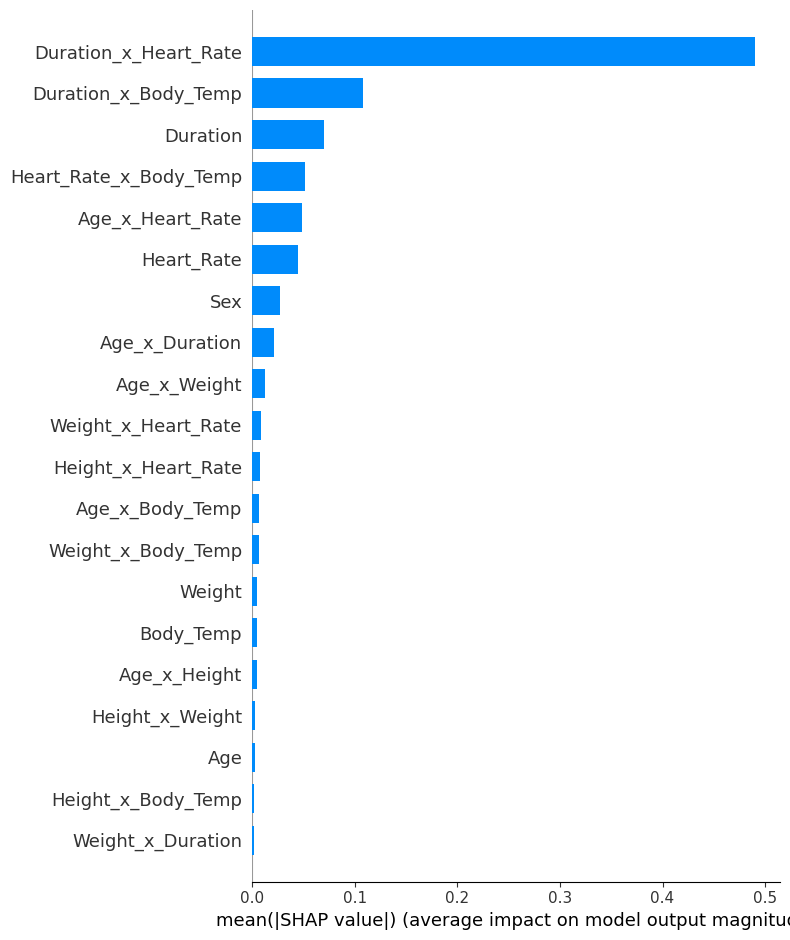


Top 20 features par importance SHAP:
1. Duration_x_Heart_Rate: 0.4899
2. Duration_x_Body_Temp: 0.1086
3. Duration: 0.0702
4. Heart_Rate_x_Body_Temp: 0.0513
5. Age_x_Heart_Rate: 0.0488
6. Heart_Rate: 0.0451
7. Sex: 0.0271
8. Age_x_Duration: 0.0216
9. Age_x_Weight: 0.0125
10. Weight_x_Heart_Rate: 0.0091
11. Height_x_Heart_Rate: 0.0081
12. Age_x_Body_Temp: 0.0066
13. Weight_x_Body_Temp: 0.0064
14. Weight: 0.0048
15. Body_Temp: 0.0047
16. Age_x_Height: 0.0044
17. Height_x_Weight: 0.0032
18. Age: 0.0025
19. Height_x_Body_Temp: 0.0024
20. Weight_x_Duration: 0.0018

Creating dependence plots...


<Figure size 1000x600 with 0 Axes>

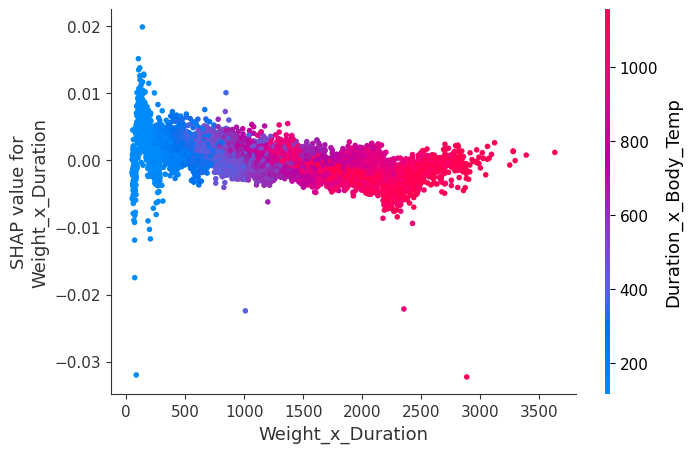

<Figure size 1000x600 with 0 Axes>

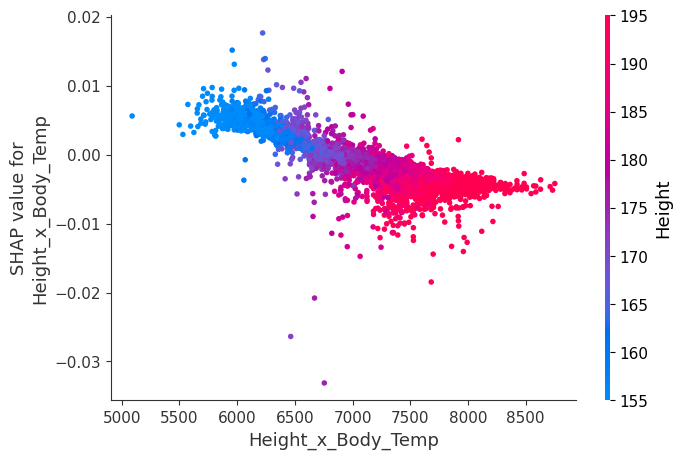

<Figure size 1000x600 with 0 Axes>

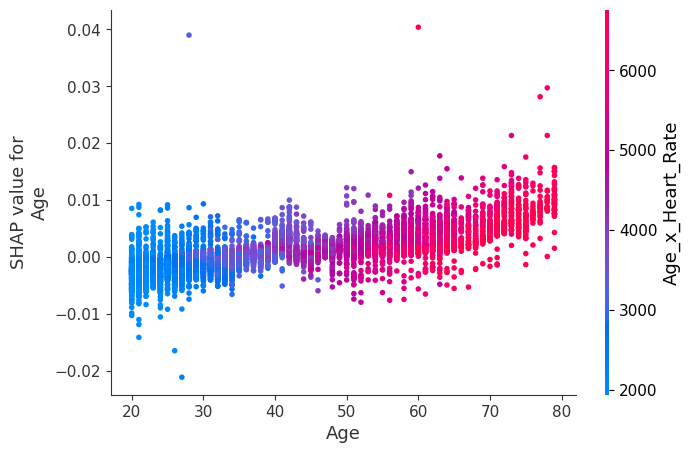

<Figure size 1000x600 with 0 Axes>

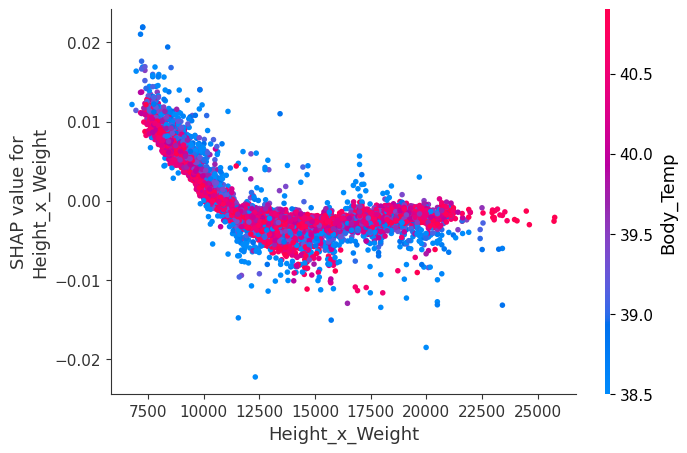

<Figure size 1000x600 with 0 Axes>

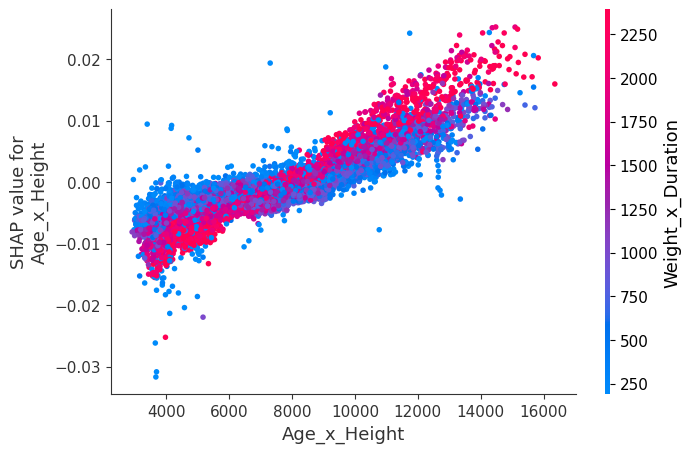

<Figure size 1000x600 with 0 Axes>

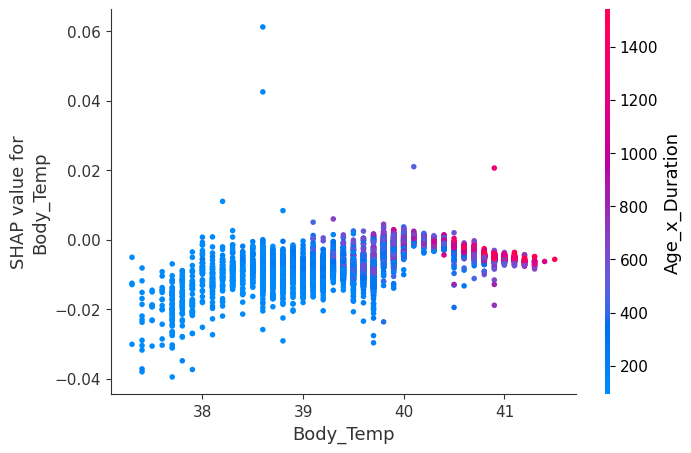

<Figure size 1000x600 with 0 Axes>

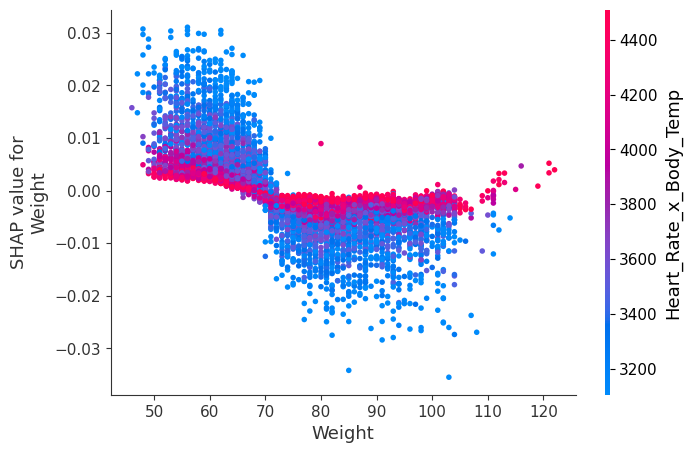

<Figure size 1000x600 with 0 Axes>

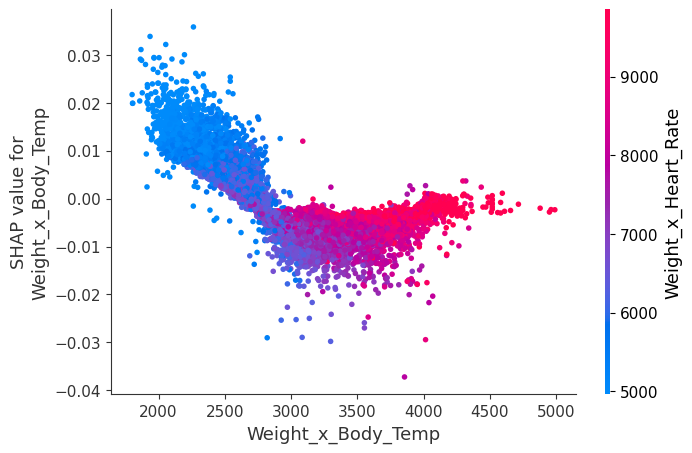

<Figure size 1000x600 with 0 Axes>

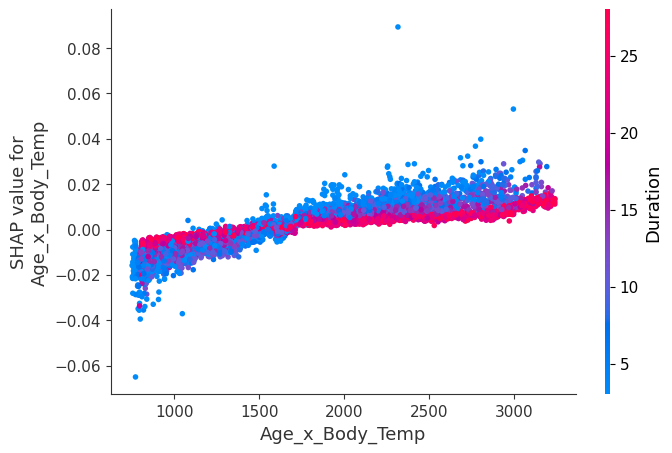

<Figure size 1000x600 with 0 Axes>

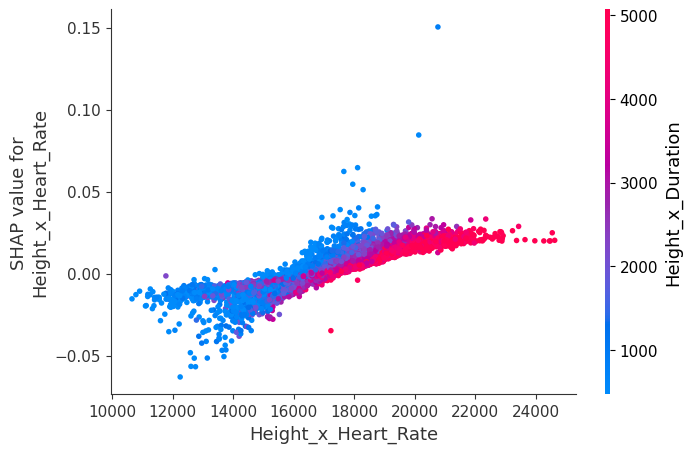

<Figure size 1000x600 with 0 Axes>

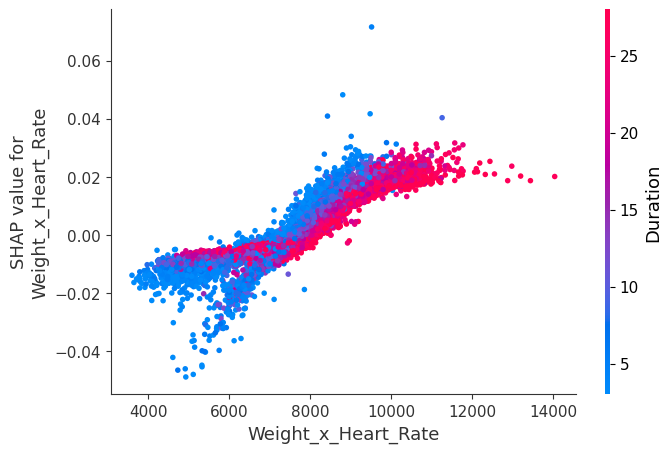

<Figure size 1000x600 with 0 Axes>

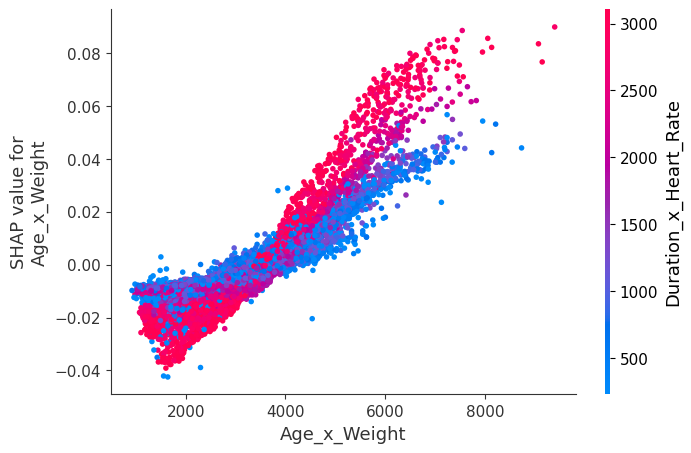

<Figure size 1000x600 with 0 Axes>

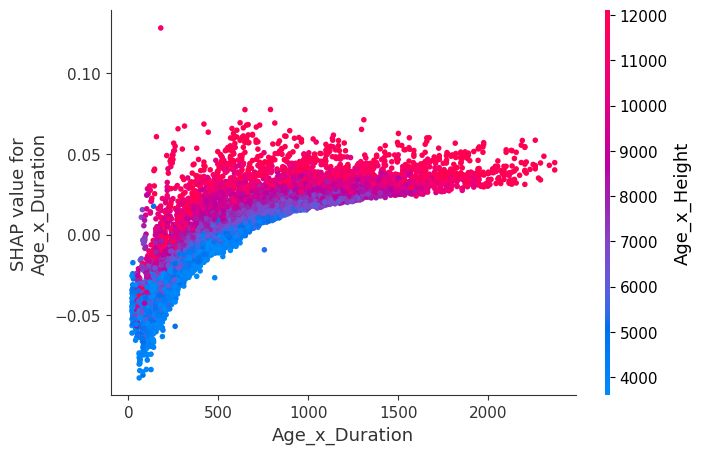

<Figure size 1000x600 with 0 Axes>

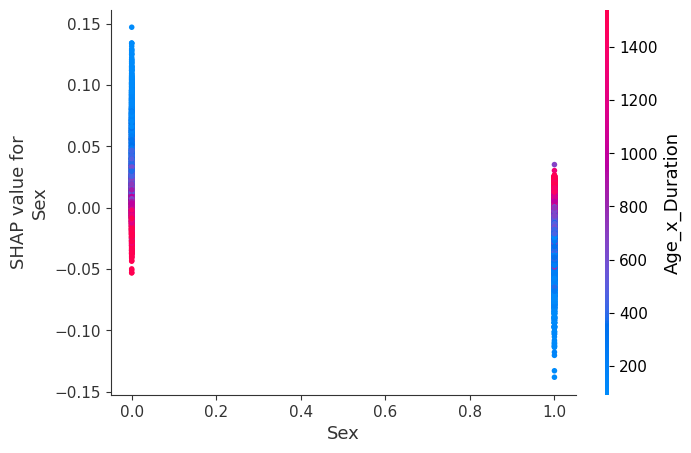

<Figure size 1000x600 with 0 Axes>

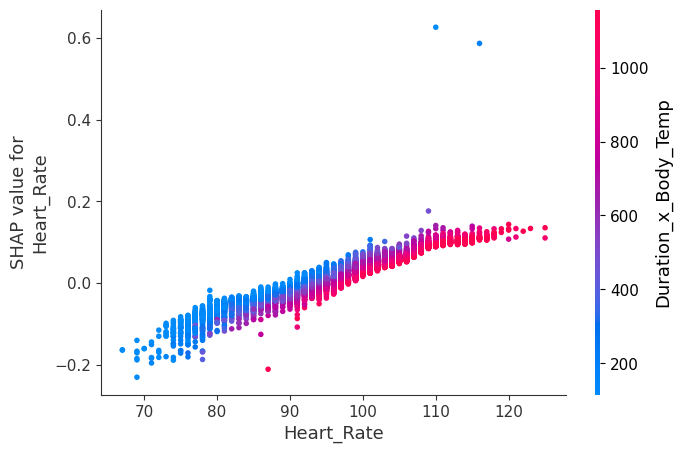

<Figure size 1000x600 with 0 Axes>

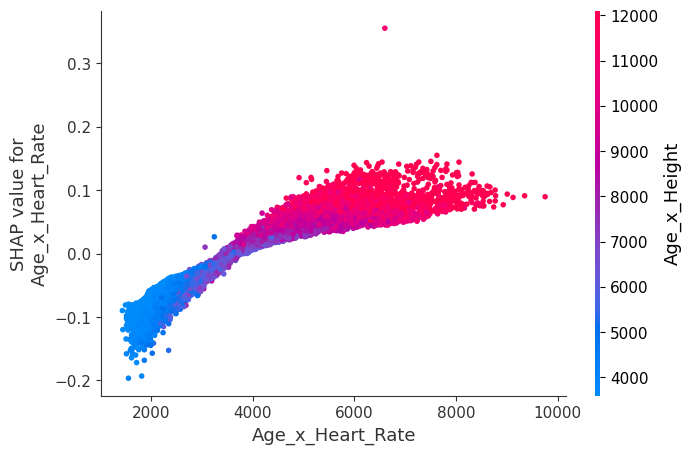

<Figure size 1000x600 with 0 Axes>

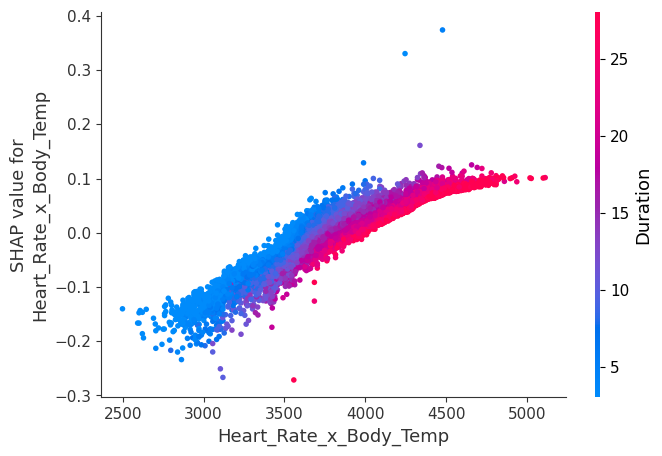

<Figure size 1000x600 with 0 Axes>

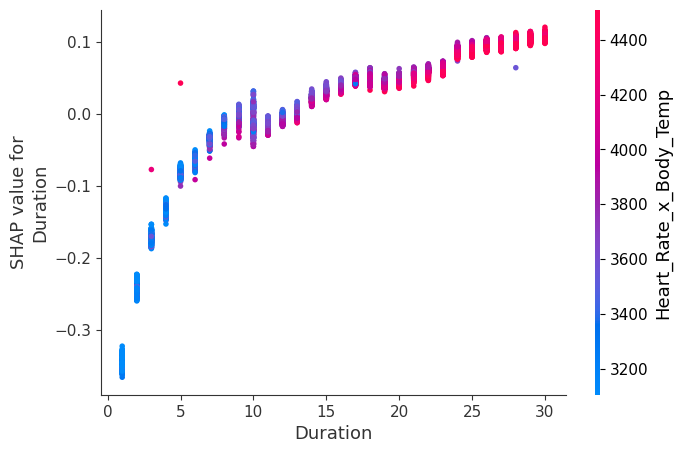

<Figure size 1000x600 with 0 Axes>

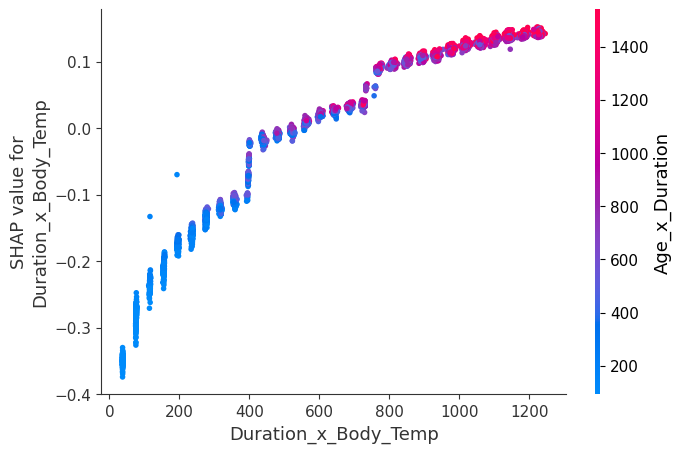

<Figure size 1000x600 with 0 Axes>

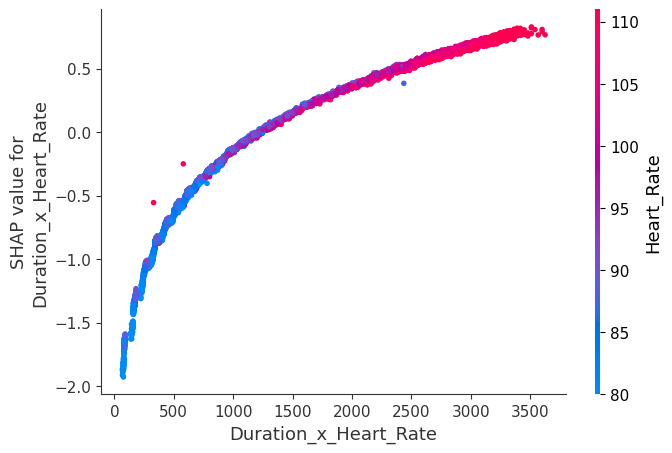

In [13]:
from xgboost import XGBRegressor


X = train_df.drop(columns=['Calories'])
y = np.log1p(train_df['Calories'])

params = {
    'max_depth': 10,
    'colsample_bytree': 0.7,
    'subsample': 0.9,
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'gamma': 0.01, 
    'max_delta_step': 2,
    'eval_metric': "rmse",
    'random_state': 42,
    'enable_categorical': True
}

model = XGBRegressor(**params)
model.fit(X, y)
feature_list = train_df.columns.tolist()

analyse_shap_values(model, X, y, n_top_features=20,  sample_size=10000)

### Ensemble

In [14]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_log_error
# import numpy as np
# import time


# X = train_df.drop(columns=['Calories'])
# y = np.log1p(train_df['Calories'])
# X_test = test_df.copy()

# # Define multiple models 
# models = {
#     'xgboost': XGBRegressor(
#         max_depth=10,
#         colsample_bytree=0.7,
#         subsample=0.9,
#         n_estimators=2000,
#         learning_rate=0.02,
#         gamma=0.01,
#         max_delta_step=2,
#         eval_metric="rmse",
#         early_stopping_rounds=100,
#         random_state=42,
#         enable_categorical=True,
#         verbose = 100
#     ),
#     'LightGBM': LGBMRegressor(
#         n_estimators=2000, 
#         learning_rate=0.02, 
#         max_depth=10, 
#         colsample_bytree=0.7,
#         subsample=0.9, 
#         random_state=42, 
#         verbose=-1),

#     'catboost': CatBoostRegressor(
#         verbose=100, 
#         random_seed=42, 
#         early_stopping_rounds=100,
#         cat_features=['Sex']),
# }

# # train models and obtain predictions 
# predictions_val, predictions_test, scores = train_multiple_models(X, y, X_test, models)

# # Show individuals scores 
# for name, score in scores.items():
#     print(f"{name}: RMSE = {score:.5f}")

In [15]:
# final_preds = np.mean(list(predictions_test.values()), axis=0)
# final_preds.shape

# submission = pd.read_csv('dataset/sample_submission.csv')
# submission["Calories"] = final_preds
# submission.to_csv("submissions/submission7.csv", index=False)
# submission.head()

In [16]:
X = train_df.drop(columns=['Calories'])
y = np.log1p(train_df['Calories'])
X_test = test_df.copy()


### Xgboost

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import time

X = train_df.drop(columns=['Calories'])
y = np.log1p(train_df['Calories'])
X_test = test_df.copy()

# Cross validation
calories_bins = pd.qcut(train_df['Calories'], q=5, labels=False)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

rmse_scores = []
test_predictions = np.zeros(len(X_test))
oof_predictions = np.zeros(len(X))  # Out-of-fold predictions

params = {
    'max_depth': 10,
    'colsample_bytree': 0.7,
    'subsample': 0.9,
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'gamma': 0.01, 
    'max_delta_step': 2,
    'eval_metric': "rmse",
    'early_stopping_rounds':100,
    'random_state': 42,
    'enable_categorical': True
}

# Loop with cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X, calories_bins)):
    print(f"\n{'='*20} Fold {fold+1}/{5} {'='*20}")
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    start_time = time.time()
    
    # Model training
    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
        )
    
    # Validation predictions - store in out-of-fold array
    fold_val_predictions = model.predict(X_val)
    oof_predictions[val_idx] = fold_val_predictions
    
    # Test predictions
    test_predictions += model.predict(X_test)
    
    # Metrics computation for this fold
    fold_rmse = np.sqrt(mean_squared_error(y_val, fold_val_predictions))
    rmse_scores.append(fold_rmse)
    
    elapsed_time = time.time() - start_time
    
    print(f"Fold {fold}:")
    print(f"RMSE: {fold_rmse:.4f}")
    print(f"Training time: {elapsed_time:.2f} seconds")

# Average test predictions across all folds
test_predictions /= 5

# Calculate average RMSE across all folds
avg_rmse = np.mean(rmse_scores)
print(f"\nAverage Fold RMSE: {avg_rmse:.4f}")

# Calculate full CV RMSE using all out-of-fold predictions
full_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
print(f"Final CV RMSE: {full_rmse:.4f}")


==================== Fold 1/5 ====================
[0]	validation_0-rmse:0.94589
[100]	validation_0-rmse:0.16321
[200]	validation_0-rmse:0.07080
[300]	validation_0-rmse:0.06222
[400]	validation_0-rmse:0.06054
[500]	validation_0-rmse:0.05994
[600]	validation_0-rmse:0.05966
[700]	validation_0-rmse:0.05954
[800]	validation_0-rmse:0.05950
[900]	validation_0-rmse:0.05950
[1000]	validation_0-rmse:0.05949
[1100]	validation_0-rmse:0.05949
[1130]	validation_0-rmse:0.05949
Fold 0:
RMSE: 0.0595
Training time: 14.91 seconds

==================== Fold 2/5 ====================
[0]	validation_0-rmse:0.94366
[100]	validation_0-rmse:0.16255
[200]	validation_0-rmse:0.07065
[300]	validation_0-rmse:0.06227
[400]	validation_0-rmse:0.06067
[500]	validation_0-rmse:0.06009
[600]	validation_0-rmse:0.05983
[700]	validation_0-rmse:0.05973
[800]	validation_0-rmse:0.05968
[900]	validation_0-rmse:0.05966
[1000]	validation_0-rmse:0.05965
[1052]	validation_0-rmse:0.05966
Fold 1:
RMSE: 0.0596
Training time: 13.32 sec

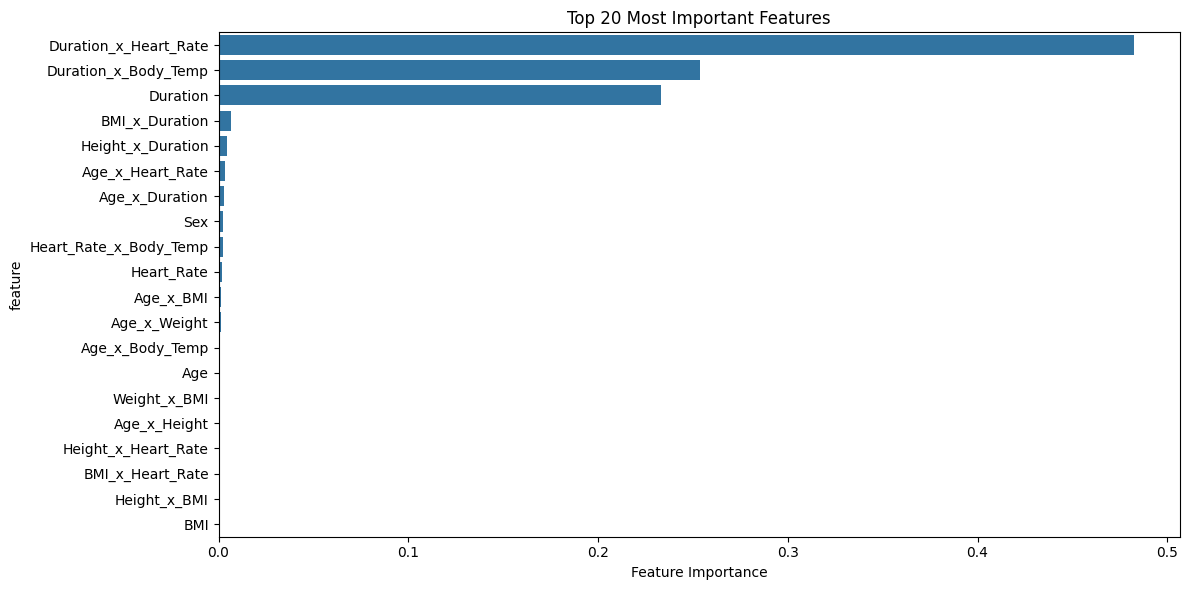


Top 20 features par importance:
                   feature  importance
26   Duration_x_Heart_Rate    0.482562
27    Duration_x_Body_Temp    0.253543
4                 Duration    0.233301
23          BMI_x_Duration    0.006504
16       Height_x_Duration    0.004487
12        Age_x_Heart_Rate    0.003264
11          Age_x_Duration    0.002933
0                      Sex    0.002385
28  Heart_Rate_x_Body_Temp    0.002243
5               Heart_Rate    0.001610
10               Age_x_BMI    0.001129
9             Age_x_Weight    0.001101
13         Age_x_Body_Temp    0.001008
1                      Age    0.000518
19            Weight_x_BMI    0.000416
8             Age_x_Height    0.000372
17     Height_x_Heart_Rate    0.000366
24        BMI_x_Heart_Rate    0.000365
15            Height_x_BMI    0.000364
7                      BMI    0.000334


In [64]:
features_names = X_train.columns.tolist()
plot_feature_importance(model, features_names)

## Submission

In [17]:
submission = pd.read_csv('dataset/sample_submission.csv')


In [18]:
predictions = np.expm1(test_predictions)
submission["Calories"] = predictions
submission.to_csv("submissions/submission9.csv", index=False)
submission.head()

,id,Calories
0,750000,27.651023
1,750001,107.702703
2,750002,87.336433
3,750003,126.786849
4,750004,75.946125


In [207]:
train_df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration_target_mean,Heart_Rate_target_mean,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,171.621655,117.517601,...,15498.0,4914.0,19089.0,7749.0,2132.0,8282.0,3362.0,2626.0,1066.0,4141.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,33.574618,25.553027,...,9780.0,1304.0,13855.0,6471.1,480.0,5100.0,2382.0,680.0,317.6,3374.5
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,28.655970,20.934958,...,10304.0,1127.0,13524.0,6407.8,448.0,5376.0,2547.2,588.0,278.6,3343.2
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,159.556908,152.130023,...,17280.0,4800.0,20160.0,7814.4,2250.0,9450.0,3663.0,2625.0,1017.5,4273.5
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,159.506813,127.093053,...,10126.0,4150.0,16932.0,6739.6,1525.0,6222.0,2476.6,2550.0,1015.0,4141.2
